In [1]:
from yamlscript_histdata import histdata_parser
from plot_classes import *
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches

In [2]:
df1, df2 = histdata_parser('CR_ttc_prefit.yaml')

histdata_parser ran in 117 ms.


In [3]:
dflist          = df1.loc[['Samples']]
hist_list       = list(reversed(df1.loc[['Samples'], 'Yield'].tolist()))
histlist_edges  = df2.loc[['BinEdges'],0][0]
histlist_labels = ['$' + x.replace('#', '\\') + '$' for x in reversed(dflist.index.get_level_values(1).tolist())]
total_yield     = df1.loc[['Total'],'Yield'][0]
data_yield      = df1.loc[['Data'],'Yield'][0]
total_errup     = df1.loc[['Total'],'Yield'][1]
total_errdown   = df1.loc[['Total'],'Yield'][2]
xaxis_label     = '$' + df2.loc[['XaxisLabel'], 0][0].replace('#', '\\') + '$'

In [4]:
len(hist_list)

19

In [24]:
from plot_classes import EmptyPlot


class PythRatio(EmptyPlot):
    
    
    def __init__(self, obj, spacing=0, stretch=4, rcp_kw={}, **kwargs):
        
        super().__init__(layout=(2,1), **kwargs)
        self.fill(obj)
        
        self.create_canvas()
        self.make_grid(hspace=spacing, height_ratios=[stretch,1])
        self.mainax = self.make_subplot(0, 1, 0, 1)
        self.botax  = self.make_subplot(1, 2, 0, 1)
        
        self.is_stackplot = False
        
        # set default rcParams for the plot
        self.rcp_dict = {'legend.handletextpad': 0.15,
                         'legend.columnspacing': 0.5,
                         'legend.labelspacing' : 0.1,
                         'legend.markerscale'  : 1.2,
                         'legend.handletextpad': 0.15,
                         'xaxis.labellocation' : 'right', # location of x label w.r.t. x axis
                         'yaxis.labellocation' : 'top', # location of y label w.r.t. y axis
                         'axes.labelpad'       : 1, # distance of axis label from axis tick labels
                         'axes.titlesize'      : 15, # master title font size
                         'font.size'           : 10, # x, y label AND ticks label AND legend font size
                         'lines.linewidth'     : 1,
                        }
        
        # update dict if user has passed any rcParam values in the constructor
        self.rcp_dict.update({k: v for k, v in rcp_kw.items() if k in mpl.rcParams})
        
        # set parameters
        self.config_rcParams(self.rcp_dict)
        
        """
        Set default error histogram parameters. These are kwargs for matplotlib.ax.stairs()
        """
        self.errhist_dict = {'color'   : 'k',
                             'alpha'   : 0.3,
                             'hatch'   : '///',
        }
        
        """
        Set default plot histogram parameters. These are kwargs for matplotlib.ax.stairs()
        """
        self.plothist_dict = {'fill': True,
                              'stack': False,
                              'edgecolor': 'k',
                              'color': 'viridis'
        }
        
        """
        Set default scatter plot parameters. These are kwargs for matplotlib.ax.errorbar()
        """
        self.scatter_dict = {'color': 'k',
                             'markersize': self.rcp_dict['font.size'],
                             'label': 'Data'
        }
        
        # create list for colors of stack plot
        if len(self.data_container) > 1:
            self.is_stackplot = True
            self.set_stack_color()
            self.plothist_dict['stack'] = True
            
        # bool if user put a custom y limits for bot plot
        self.custom_ylims = False

        
    def fill(self, obj):
        
        if isinstance(obj, list):
            self.data_container = obj
        else:
            self.data_container.append(obj)
            self.active_data = self.data_container[0]

        self.store_data()
    
    
    def store_data(self):
        
        ### these should be retrived internally from filled object ---------------------
        self.dflist          = dflist
        self.histlistedges   = histlist_edges
        self.histlisttotal   = total_yield
        self.histlistdata    = data_yield
        self.histlistlabels  = histlist_labels
        self.histlisterrup   = total_errup
        self.histlisterrdown = total_errdown
        # the lower part in the ratio plot is the data divided by the total hist cont
        self.ratiovalues = [i/j for i, j in zip(self.histlistdata, self.histlisttotal)]
        ### ----------------------------------------------------------------------------
        
    
    def set_stack_color(self, colormap='viridis', reverse=False):
        """ 
        Create custom color map for stack histogram
        """
        
        clist = []
        n = len(self.dflist)
        pct_max, pct_min = 99, 1 # max and min percentile of color ramp
        cmap = mpl.cm.get_cmap(colormap)
        
        # list of values between 0.00 and 1.00; length equals length of data source
        sequence = list(i/100 for i in (np.arange(pct_min, pct_max, (pct_max-pct_min)/n)))
        
        # reverse if required
        sequence = sequence if not reverse else reversed(sequence)
        
        # create list of colors
        for i in sequence:
            color = cmap(i) 
            clist.append(color)
        
        self.stack_colorlist = clist
        self.plothist_dict['color'] = self.stack_colorlist        

        
    def set_mainax(self):
        """
        Main plot
        """
        
        # hist plot
        if self.is_stackplot:
            hep.histplot(self.data_container, ax=self.mainax, bins=self.histlistedges, label=self.histlistlabels, **self.plothist_dict)
        # else:
        
        
        # data scatter points
        hep.histplot(self.histlistdata, ax=self.mainax, bins=self.histlistedges, histtype='errorbar', **self.scatter_dict)
        
        # adjust ticks
        self.mainax.tick_params(direction='in', length=10, bottom=True, top=True, left=True, right=True,
                                labelsize=self.rcp_dict['font.size'])
        self.mainax.tick_params(direction='in', which='minor', length=5, bottom=True, top=True, left=True, right=True)
        
        # show full numbers without scientific notation
        self.mainax.ticklabel_format(style='plain')
        
        self.mainax.set_xticks(np.linspace(self.histlistedges[0], self.histlistedges[-1], len(self.histlistedges)))
        self.mainax.set_xticklabels([]) # suppress x tick labels for main plot
        
        # add atlas logo and text
        hep.atlas.label(ax=self.mainax, label='Internal', data=True, lumi=139)
        
        # set legend
        self.set_legend()
        
        
    def make_baseline(self, errs):
        """
        Create baseline for error histogram bins
        """
        
        return [self.histlisttotal[i] + errs[i] for i in range(len(self.histlisttotal))]
    
    
    def make_ratioerrs(self, errs):
        """
        Create ratio error values
        """
        
        return [(self.histlisttotal[i] + errs[i])/self.histlisttotal[i] for i in range(len(self.histlisttotal))]
            
        
    def plot_errors(self, label='Uncertainty', **errors_kw):
        """
        Callable by user to change error histogram parameters for both main and bot plots
        """

        # update user input
        self.errhist_dict.update(errors_kw)
        
        # mainax
        self.mainax.stairs(self.histlisttotal, edges=self.histlistedges, baseline=self.make_baseline(self.histlisterrup),
                           label=label, **self.errhist_dict)
        self.mainax.stairs(self.histlisttotal, edges=self.histlistedges, baseline=self.make_baseline(self.histlisterrdown),
                           **self.errhist_dict)
        # botax
        self.botax.stairs(self.make_ratioerrs(self.histlisterrup), edges=self.histlistedges,
                          baseline=1, **self.errhist_dict)
        self.botax.stairs(self.make_ratioerrs(self.histlisterrdown), edges=self.histlistedges, 
                          baseline=1, **self.errhist_dict)

        
    def set_legend(self):
        
        self.mainax.legend(ncol=2, handlelength=mpl.rcParams['legend.handleheight']+0.04, fontsize=self.rcp_dict['font.size'])
        
        # scale ylim automatically for optimal legend placement
        hep.plot.yscale_legend(ax=self.mainax)
        
        # sort legend entries
        hep.sort_legend(self.mainax)

        
    def set_botax(self):

        # ratio scatter data
        hep.histplot(self.ratiovalues, ax=self.botax, bins=self.histlistedges, histtype='errorbar', **self.scatter_dict)
        
        # adjust ticks
        self.botax.tick_params(direction='in', length=10, bottom=True, top=True, left=True, right=True,
                               labelsize=self.rcp_dict['font.size'])
        self.botax.tick_params(direction='in', which='minor', length=5, bottom=True, top=True, left=True, right=True)
        
        self.botax.set_xticks(np.linspace(self.histlistedges[0], self.histlistedges[-1], len(self.histlistedges)))
        
        # draw horizontal line at y=1
        self.botax.axhline(1, color='k', linestyle='--')

        if self.custom_ylims:
            self.botax.set_ylim(self.ylims)
            self.set_bot_yticks()
        
        
    def set_bot_yticks(self):
                
        self.botax.set_yticks(self.ybotrange)
        self.botax.set_yticklabels(self.ybotlabels, fontsize=self.rcp_dict['font.size'])
        
        
    def set_bot_yaxis(self, ylims, step, edges=True):
        """
        Allow user to manually change the bot ax y limits, which can often
        overlap with various other plot elements. If edges is set to False,
        the first and last ticks will be omitted to make space in the plot.
        """
        
        self.custom_ylims = True
        
        self.ylims = ylims
        self.ystep = step
        self.ybotrange = np.arange(ylims[0], ylims[-1]+step, step)
        self.ybotlabels = [f'{x:.2f}' for x in self.ybotrange]
        
        if not edges:
            self.ybotlabels[0] = ''
            self.ybotlabels[-1] = ''
        
        
    def axes_labels(self, fontsize, labelpad=5, **titles_kw):
        """
        Set axis labels (also called titles here) according to user input
        """
        
        self.fill_titlesdict(**titles_kw)
        self.set_xtitles(self.botax, 'xbot', fontsize=fontsize, labelpad=labelpad)
        self.set_ytitles(self.mainax, 'ymain', fontsize=fontsize, labelpad=labelpad)
        self.set_ytitles(self.botax, 'ybot', fontsize=fontsize, labelpad=labelpad)
        
        
    def ratio_plot(self):
        
        self.set_mainax()
        self.set_botax()
        
        # errors
        self.plot_errors()
        
        # set master title
        self.mainax.set_title(self.master_title, fontsize=self.rcp_dict['axes.titlesize'])

        
    def display(self, save_name='', dpi=1000):
        
        self.ratio_plot()
        
        if save_name:
            self.saveimage(save_name, dpi)

legend.handletextpad 0.15
legend.columnspacing 0.5
legend.labelspacing 0.1
legend.markerscale 1.2
xaxis.labellocation right
yaxis.labellocation top
axes.labelpad 1
axes.titlesize 20
font.size 11
lines.linewidth 1


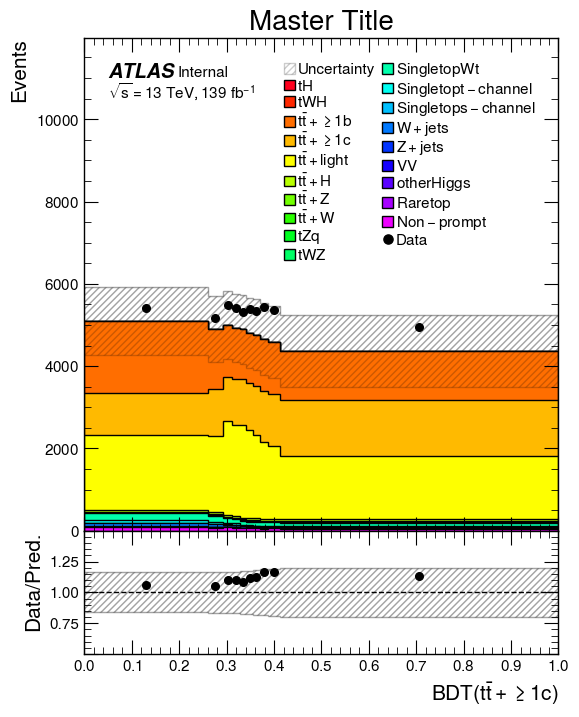

In [27]:
my_dict={'axes.titlesize': 20,
         'font.size': 11
        }

obj = PythRatio(hist_list, size=(6,8), title='Master Title', spacing=0, rcp_kw=my_dict)
obj.set_stack_color(reverse=True, colormap='gist_rainbow')
obj.axes_labels(15, xbot=xaxis_label, ymain='Events', ybot='Data/Pred.')
obj.set_bot_yaxis([0.5, 1.5], 0.25, edges=False) # strongly recommend user to do this
obj.plot_errors(hatch='/////', alpha=0.2)
obj.display()